In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip 'drive/My Drive/daly_images.zip'

Показано результат, скорочений до останніх рядків (5000).
  inflating: daly_images/OvlvkI4Wlgo.mp4/img_5.58.jpg  
  inflating: daly_images/OvlvkI4Wlgo.mp4/img_6.46.jpg  
  inflating: daly_images/OvlvkI4Wlgo.mp4/img_7.34.jpg  
  inflating: daly_images/OvlvkI4Wlgo.mp4/img_81.14.jpg  
  inflating: daly_images/OvlvkI4Wlgo.mp4/img_82.47.jpg  
  inflating: daly_images/OvlvkI4Wlgo.mp4/img_83.79.jpg  
  inflating: daly_images/OvlvkI4Wlgo.mp4/img_85.12.jpg  
  inflating: daly_images/OvlvkI4Wlgo.mp4/img_86.44.jpg  
   creating: daly_images/OYdfDmyw6Y0.mp4/
  inflating: daly_images/OYdfDmyw6Y0.mp4/img_125.40.jpg  
  inflating: daly_images/OYdfDmyw6Y0.mp4/img_147.11.jpg  
  inflating: daly_images/OYdfDmyw6Y0.mp4/img_148.01.jpg  
  inflating: daly_images/OYdfDmyw6Y0.mp4/img_148.91.jpg  
  inflating: daly_images/OYdfDmyw6Y0.mp4/img_149.81.jpg  
  inflating: daly_images/OYdfDmyw6Y0.mp4/img_150.71.jpg  
  inflating: daly_images/OYdfDmyw6Y0.mp4/img_162.96.jpg  
  inflating: daly_images/OYdfDmyw6Y0.mp4/

In [3]:
import pickle
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [60]:
def parse_annots(annots_file,width=1280,height=720):
    with open(annots_file, "rb") as f:
        daly = pickle.load(f, encoding='latin1')
    rows=[]
    columns=['photo_path','label','xmin','ymin','xmax','ymax']
    for vid in daly['annot'].keys():
        action_list=list(daly['annot'][vid]['annot'].keys())
        for action in action_list:
            act=daly['annot'][vid]['annot'][action]
            for i in range(len(act)):
                for j in range(len(act[i]['keyframes'])):
                    time=str(act[i]['keyframes'][j]['time'])
                    if len(time.split('.')[1])==1:
                        time=time+'0'
                    path='daly_images/'+vid+'/img_'+time+'.jpg'
                    bbox=np.array(*act[i]['keyframes'][j]['boundingBox'],dtype=np.float32)
                    rows.append([path,action,width*bbox[0],height*bbox[1],width*bbox[2],height*bbox[3]])
    return pd.DataFrame(rows,columns=columns)

In [61]:
annots_file='daly1.1.0.pkl'

df=parse_annots(annots_file)
labels={k:v for v,k in enumerate(sorted(set(df['label'])))}
print(labels)
df['label']=df['label'].apply(lambda x:labels[x])

{'ApplyingMakeUpOnLips': 0, 'BrushingTeeth': 1, 'CleaningFloor': 2, 'CleaningWindows': 3, 'Drinking': 4, 'FoldingTextile': 5, 'Ironing': 6, 'Phoning': 7, 'PlayingHarmonica': 8, 'TakingPhotosOrVideos': 9}


In [6]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def transformsXY(path, bb):
    x = cv2.imread(str(path))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    
    return x, mask_to_bb(Y)

In [7]:
def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x,size):
    """Generates bounding box array from a train_df row"""
    return np.array([int(x[3]),int(x[2]),int(x[5]),int(x[4])])

def resize_image_bb(read_path,bb,size):
    """Resize an image and its bounding box and write image to new path"""
    im = cv2.cvtColor(cv2.imread(str(read_path)), cv2.COLOR_BGR2RGB)
    im_resized = cv2.resize(im, (size, size))
    Y_resized = cv2.resize(create_mask(bb, im), (size, size))
    #new_path = str(write_path/Path(read_path).parts[-1])
    new_path=str(read_path[:-4]+'resized'+ read_path[-4:])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [8]:
image_size = 300
new_paths = []
new_bbs = []
#train_path_resized = Path('./daly_images/images_resized')
for index, row in df.iterrows():
    new_path,new_bb = resize_image_bb(row['photo_path'],  create_bb_array(row.values,image_size),image_size)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df['new_path'] = new_paths
df['new_bb'] = new_bbs

In [9]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [10]:
X=df[['new_path','new_bb']]
Y=df['label']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

In [13]:
X_train=X_train.reset_index(drop=True)
X_val=X_val.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_val=y_val.reset_index(drop=True)
print(y_val.head())

0    0
1    3
2    1
3    5
4    1
Name: label, dtype: int64


In [14]:
class DALY(torch.utils.data.Dataset):
    def __init__(self,images_path,labels,boxes):
        
        self.images_path=images_path
        self.labels=labels
        self.boxes=boxes       
        
    def __len__(self):
        return len(self.images_path)
       
    def __getitem__(self,idx):
        path = self.images_path[idx]
        label = self.labels[idx]
        x, y_bb = transformsXY(path, self.boxes[idx])
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, label, y_bb
       
daly_train=DALY(X_train['new_path'],y_train,X_train['new_bb'])
daly_test=DALY(X_val['new_path'],y_val,X_val['new_bb'])

print(daly_test.__len__())


2389


In [15]:
batch_size = 64
train_data = DataLoader(daly_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(daly_test, batch_size=batch_size)

In [16]:
class Detector(torch.nn.Module):
    def __init__(self,num_classes=10):
        super(Detector, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, num_classes))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)


In [17]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [18]:
def train_epocs(model, optimizer, train_data, test_data, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y, box in train_data:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            box = box.cuda().float()
            out_class, out_box = model(x)
            loss_class = F.cross_entropy(out_class, y, reduction="sum")
            loss_bb = F.l1_loss(out_box, box, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = test_metrics(model, test_data, C)
        torch.save(model.state_dict(),'weights.pth')
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [19]:
def test_metrics(model, test_data, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y, box in test_data:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        box = box.cuda().float()
        out_class, out_box = model(x)
        loss_class = F.cross_entropy(out_class, y, reduction="sum")
        loss_bb = F.l1_loss(out_box, box, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [20]:
model = Detector().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [21]:
train_epocs(model, optimizer, train_data, test_data, epochs=10)


train_loss 2.571 val_loss 3.915 val_acc 0.239
train_loss 2.226 val_loss 2.816 val_acc 0.229
train_loss 2.014 val_loss 2.238 val_acc 0.442
train_loss 1.540 val_loss 1.941 val_acc 0.589
train_loss 1.154 val_loss 2.727 val_acc 0.597
train_loss 0.838 val_loss 1.264 val_acc 0.735
train_loss 0.627 val_loss 0.782 val_acc 0.823
train_loss 0.497 val_loss 0.768 val_acc 0.840
train_loss 0.389 val_loss 0.737 val_acc 0.840
train_loss 0.357 val_loss 0.738 val_acc 0.827


0.35659846496901454

In [38]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_data, test_data, epochs=10)

train_loss 0.113 val_loss 0.297 val_acc 0.954
train_loss 0.105 val_loss 0.281 val_acc 0.956
train_loss 0.103 val_loss 0.277 val_acc 0.957
train_loss 0.100 val_loss 0.281 val_acc 0.959
train_loss 0.096 val_loss 0.283 val_acc 0.959
train_loss 0.092 val_loss 0.290 val_acc 0.955
train_loss 0.089 val_loss 0.294 val_acc 0.956
train_loss 0.088 val_loss 0.296 val_acc 0.952
train_loss 0.084 val_loss 0.288 val_acc 0.959
train_loss 0.082 val_loss 0.283 val_acc 0.957


0.0817713135576957

In [82]:
#model.load_state_dict(torch.load('weights.pth', map_location="cuda:0"))
im=cv2.imread('daly_images/uSOqmcWMAD0.mp4/img_54.15resized.jpg')
im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
#reshaped=im.reshape(1,3,300,300)
# test_ds = DALY(pd.DataFrame([{'path':'daly_images/Tuz10DjHxQI.mp4/img_214.25resized.jpg'}])['path'],pd.DataFrame([{'y':[0]}])['y'],pd.DataFrame([{'bounding_box':np.array([0,0,0,0])}])['bounding_box'])
# x,y,box=test_ds[0]
im_norm=normalize(im)
im_norm=np.rollaxis(im_norm,2)

reshaped=im_norm.reshape(3,image_size,image_size)
xx = torch.FloatTensor(reshaped[None,])
print(xx.shape)

torch.Size([1, 3, 300, 300])


In [83]:
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[-8.0438, -0.3171,  6.0707, -5.0170,  1.6910,  8.4565,  2.2195, -2.0014,
          -2.8045,  1.7765]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 33.2837,  89.7299, 155.2033, 209.6104]], device='cuda:0',
        grad_fn=<AddmmBackward>))

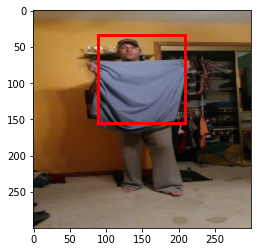

In [84]:
# class_predicted=int(torch.argmax(out_class))
# print(labels)
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [103]:
def prepare_to_predict(image:np.array,image_size):
    im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255
    im_norm = normalize(im)
    im_norm = np.rollaxis(im_norm, 2)
    reshaped = im_norm.reshape(3, frame.shape[0], frame.shape[1])
    return torch.FloatTensor(reshaped[None,])

In [107]:
video_path='uSOqmcWMAD0.mp4'

cap = cv2.VideoCapture(video_path)
image_size=300
fps = cap.get(cv2.CAP_PROP_FPS)
# width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
# height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

font = cv2.FONT_HERSHEY_SIMPLEX
frame_number=0
#### save video

fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
output_video_name = video_path.split('.')[0] + '_output.avi'
out = cv2.VideoWriter(output_video_name, fourcc, fps, (image_size, image_size))

while(cap.isOpened()):
    # frame_number = frame_number + 1
    # print(str(frame_number))

    ret, frame = cap.read()

    if ret == True:
        frame = cv2.resize(frame,(image_size,image_size),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        #print(frame.shape)
        frame_to_predict=prepare_to_predict(frame)
        out_class, out_bb = model(frame_to_predict.cuda())
        predicted_class = list(labels)[torch.argmax(out_class)]
        print(predicted_class)

        xmin = out_bb[0][0].detach().cpu().numpy()
        ymin = out_bb[0][1].detach().cpu().numpy()
        xmax = out_bb[0][2].detach().cpu().numpy()
        ymax = out_bb[0][3].detach().cpu().numpy()
        
        frame = cv2.rectangle(frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255,0,0), 5)
        cv2.putText(frame, predicted_class, (int(xmin) + 10, int(ymin) + 30), font, 1, (255,0,0), 3, cv2.LINE_AA)


        out.write(frame)

        #cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
out.release()


FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
CleaningFloor
CleaningFloor
CleaningFloor
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
CleaningFloor
FoldingTextile
FoldingTextile
FoldingTextile
CleaningFloor
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile
FoldingTextile


In [108]:
!ffmpeg -i uSOqmcWMAD0_output.avi output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [109]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()


In [110]:
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)